In [ ]:
# download data
!curl -o ~/data/chexpert_downsample.zip -L 'https://urldefense.com/v3/__https:/us13.mailchimp.com/mctx/clicks?url=http*3A*2F*2Fdownload.cs.stanford.edu*2Fdeep*2FCheXpert-v1.0-small.zip&h=ea404bbb7c44a38cdb4d7d164381cf0991a7cd1ab8da9118cf81f4212529240c&v=1&xid=e611079ec0&uid=55365305&pool=contact_facing&subject=CheXpert-v1.0*3A*Subscription*Confirmed__;JSUlJSUlKys!!DZ3fjg!vv2P_dVwmPh6EYoMCBaVySJK1bhdenEkEj1cXvJyj_hj1_OkbF5irUmtsi96IuYarOw$'

In [ ]:
# unzip
!sudo apt-get install unzip
!unzip ~/data/chexpert_downsample.zip

In [ ]:
# copy zip and unzipped files to GCS
!gsutil -m cp ~/data/chexpert_downsample.zip gs://dlh-chexpert/
!gsutil -m -q cp -r CheXpert-v1.0-small/ gs://dlh-chexpert/

In [4]:
# reverse: grab data from GCS
!gsutil -m -q cp -r gs://dlh-chexpert/CheXpert-v1.0-small .
print("Done.")

Done.


# Code starts here

In [1]:
import pandas as pd
import numpy as np
import random
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
    
ROOT_PATH = os.getcwd()
FOLDER_PATH = os.path.join(ROOT_PATH, 'CheXpert-v1.0-small')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


In [2]:
# explore the dataset
# load data label
df_train_labels = pd.read_csv(os.path.join(FOLDER_PATH, 'train.csv'))
df_valid_labels = pd.read_csv(os.path.join(FOLDER_PATH, 'valid.csv'))

print(f"Train samples: {df_train_labels.shape[0]}")
print(f"Valid samples: {df_valid_labels.shape[0]}")

Train samples: 223414
Valid samples: 234


In [3]:
df_train_labels.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [4]:
# TODO: get doc on features
df_train_labels.describe(include='all')

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
count,223414,223414,223414.000000,223414,191027,22381.0,44839.000000,46203.000000,117778.000000,11944.000000,85956.000000,70622.000000,27608.000000,68443.000000,78934.000000,133211.000000,6492.000000,12194.000000,123217.000000
unique,223414,3,NaN,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,CheXpert-v1.0-small/train/patient37972/study3/...,Male,NaN,Frontal,AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,132636,NaN,191027,161590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,60.430653,NaN,NaN,1.0,-0.035795,0.409346,0.848911,0.644508,0.456769,-0.183498,-0.461134,-0.005304,0.206540,0.559706,0.134011,0.688699,0.932680
std,NaN,NaN,17.820925,NaN,NaN,0.0,0.718442,0.769323,0.472571,0.691607,0.741785,0.753980,0.828249,0.990244,0.493529,0.648859,0.966183,0.565435,0.283377
min,NaN,NaN,0.000000,NaN,NaN,1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,NaN,NaN,49.000000,NaN,NaN,1.0,-1.000000,0.000000,1.000000,1.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,1.000000
50%,NaN,NaN,62.000000,NaN,NaN,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,NaN,NaN,74.000000,NaN,NaN,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000


For labels: **blank** for unmentioned, **0** for negative, **-1** for uncertain, and **1** for positive.

In [5]:
df_train_labels.columns

Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices'],
      dtype='object')

In [6]:
# read images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
i=1

print(df_train_labels['Path'][i])
img=mpimg.imread(df_train_labels['Path'][i])
#print(img.shape)  # 2D. Size varies.
#print(img.max(), img.min())  # grayscale 0-255
print(df_train_labels['Age'][i])
print(df_train_labels['Sex'][i])
print(df_train_labels['Frontal/Lateral'][i])
print(df_train_labels['AP/PA'][i])

CheXpert-v1.0-small/train/patient00002/study2/view1_frontal.jpg
87
Female
Frontal
AP


In [7]:
df_train_labels.loc[0:13,'Sex']

0     Female
1     Female
2     Female
3     Female
4       Male
5     Female
6     Female
7       Male
8       Male
9       Male
10      Male
11    Female
12      Male
13      Male
Name: Sex, dtype: object

Note that the size of images varies.

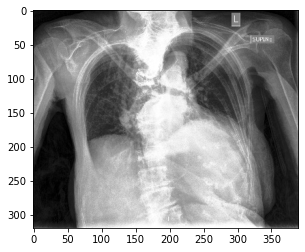

In [8]:
imgplot = plt.imshow(img, cmap='gray')

Take the label *Pleural Effusion* as pivot, let's build a classifier for it.

Settings:
1. Consider only Frontal view images.
2. U-MultiClass for Pleural Effusion - treat the uncertainty label (-1) as its own class.
3. Null(NA) values are treated as *negative (0)*.

In [9]:
# 1. Select training images
def select_images(df):
    df = df[df['Frontal/Lateral']=='Frontal']
    df = df[['Path', 'Pleural Effusion']].fillna(0)  # Note that '0' is negative, '-1' is uncertain. We assume NA => Unmentioned => Negative => 0.
    return df.reset_index()

df_frontal = select_images(df_train_labels)

Pleural Effusion
-1.0      9578
 0.0    104550
 1.0     76899
dtype: int64

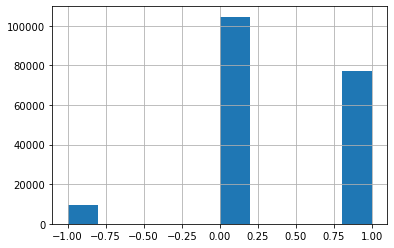

In [10]:
df_frontal.describe(include='all')
df_frontal['Pleural Effusion'].hist()

df_frontal.groupby(['Pleural Effusion']).size()

In [11]:
# Prepare train and validation data
df_train = select_images(df_train_labels)
df_valid = select_images(df_valid_labels)

print(f"# training images: {df_train.shape[0]}")
print(f"# validation images: {df_valid.shape[0]}")

# training images: 191027
# validation images: 202


**Warning: The validation images serve as test set. Do NOT use them for model tuning.**
Use leave-out set/CV on training images for tuning instead.

Now we have the images and labels. We can train our model.

In [12]:
# set seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

0
(374, 320)


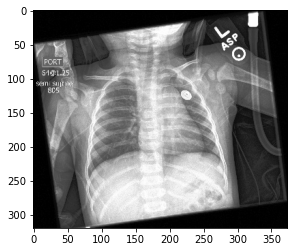

In [13]:
# Loader
target_dict = {
    -1: 2,  # uncertain
    0: 0,  # negative
    1: 1  # positive
}

class CheXpertDataset(Dataset):
    def __init__(self, dataframe, root_dir, label, transform=None):
        """
        label: column name of the label of interest, e.g. 'Pleural Effusion'.
        """
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.label = label
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.loc[idx, 'Path'])
        image = Image.open(img_name)
        target = self.dataframe.loc[idx, self.label]
        target = target_dict[target]  # map labels to 0,...,num_classes
        
        if self.transform:
            image = self.transform(image)
        
        return (image, target)

# For testing/debug
ds= CheXpertDataset(df_train, ROOT_PATH, 'Pleural Effusion')
img, label = ds[191027-1]
print(label)
print(img.size)
imgplot = plt.imshow(img, cmap='gray')

In [14]:
# train_loader: train data loader (type: torch.utils.data.DataLoader)
# val_loader: val data loader (type: torch.utils.data.DataLoader)
def load_data(dataframe, root_dir, label, transform=None, batch_size=32, shuffle=True, num_workers=4):
    '''
    Data Loader with batch loading and transform.
    '''
    image_data = CheXpertDataset(dataframe, root_dir, label, transform=transform)
    loader = torch.utils.data.DataLoader(image_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=True)
    return loader

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),  # data augmentation
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Define our CNN architecture:

In [15]:
# Helper function
def conv_output_volume(W, F, S, P):
    
    """
    Given the input volume size $W$, the kernel/filter size $F$, 
    the stride $S$, and the amount of zero padding $P$ used on the border, 
    calculate the output volume size.
    """
    return int((W - F + 2*P) / S) + 1

def maxpool_output_volume(W, F, S):
    
    """
    Given the input volume size $W$, the kernel/filter size $F$, 
    the stride $S$, and the amount of zero padding $P$ used on the border, 
    calculate the output volume size.
    """
    return int(np.ceil((W - F + 1) / S))

conv_layer1_size = conv_output_volume(W=224, F=5, S=1, P=0)
maxpool_layer1_size = maxpool_output_volume(W=conv_layer1_size, F=2, S=2)

conv_layer2_size = conv_output_volume(W=maxpool_layer1_size, F=5, S=1, P=0)
maxpool_layer2_size = maxpool_output_volume(W=conv_layer2_size, F=2, S=2)

print(conv_layer1_size, maxpool_layer1_size, conv_layer2_size, maxpool_layer2_size)

220 110 106 53


In [16]:
# For now, just use a simple one from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html, plus dropout

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5)  # stride=1, padding=0
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(3, 8, 5)
        self.fc1 = nn.Linear(8 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)  # 3 classes
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # size: (batch_size*)3channels*110*110
        x = self.pool(F.relu(self.conv2(x)))  # size: (batch_size*)8channels*53*53
        x = x.view(-1, 8 * 53 * 53)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


net = Net().to(device)

In [17]:
# Define loss function and optimizer

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [18]:
# Train

import time

num_epochs = 1
batch_size = 1024

train_data_loader = load_data(df_train, ROOT_PATH, 'Pleural Effusion', transform=data_transforms['train'], shuffle=True, batch_size=batch_size)
val_data_loader = load_data(df_valid, ROOT_PATH, 'Pleural Effusion', transform=data_transforms['val'], shuffle=False, batch_size=batch_size)

print(f"Training start. Mode: {device}")
start_time = time.time()

net.train()
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print(f"Epoch {epoch}")
    
    running_loss = 0.0
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        # cast label data type to int
        labels = labels.type(torch.LongTensor).to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            print(f"Average time per batch: {(time.time()-start_time)/(i+1)} secs")
            running_loss = 0.0

print(f'Finished Training. Total time: {time.time()-start_time} secs.')

Training start. Mode: cuda
Epoch 0
[1,    10] loss: 1.130
Average time per batch: 2.302246880531311 secs
[1,    20] loss: 1.113
Average time per batch: 1.902261447906494 secs
[1,    30] loss: 1.089
Average time per batch: 1.9386913855870564 secs
[1,    40] loss: 1.067
Average time per batch: 1.8157589077949523 secs
[1,    50] loss: 1.046
Average time per batch: 1.8370158529281617 secs
[1,    60] loss: 1.014
Average time per batch: 1.76354478597641 secs
[1,    70] loss: 0.973
Average time per batch: 1.7760166713169643 secs
[1,    80] loss: 0.909
Average time per batch: 1.729964581131935 secs
[1,    90] loss: 0.866
Average time per batch: 1.7380404551823934 secs
[1,   100] loss: 0.861
Average time per batch: 1.6989265084266663 secs
[1,   110] loss: 0.860
Average time per batch: 1.7079211343418468 secs
[1,   120] loss: 0.858
Average time per batch: 1.6828196823596955 secs
[1,   130] loss: 0.859
Average time per batch: 1.6991483835073617 secs
[1,   140] loss: 0.849
Average time per batch: 

In [18]:
# save state
MODEL_PATH = './simple_net.pth'
torch.save(net.state_dict(), MODEL_PATH)

In [19]:
# Test on validation set

# Load the saved model if necessary
net = Net().to(device)
net.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [21]:
def eval_model(model, dataloader):
    """
    :return:
        Y_pred: prediction of model on the dataloder.
            Should be an 2D numpy float array where the second dimension has length 2.
        Y_test: truth labels. Should be an numpy array of ints
    """
    model.eval()
    Y_prob = []
    Y_pred = []
    Y_test = []
    for data, target in dataloader:
        outputs = model(data.to(device))
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        Y_prob.append(probs)
        Y_pred.append(predicted)
        Y_test.append(target)
        
    Y_prob = np.concatenate(Y_prob, axis=0)
    Y_pred = np.concatenate(Y_pred, axis=0)
    Y_test = np.concatenate(Y_test, axis=0)

    return Y_prob, Y_pred, Y_test


from sklearn.metrics import accuracy_score, roc_auc_score
# lower batch size if out of memory
train_data_loader = load_data(df_train, ROOT_PATH, 'Pleural Effusion', transform=data_transforms['train'], shuffle=True, batch_size=64)
val_data_loader = load_data(df_valid, ROOT_PATH, 'Pleural Effusion', transform=data_transforms['val'], shuffle=False, batch_size=64)

y_prob, y_pred, y_true = eval_model(net, train_data_loader)
acc = accuracy_score(y_true, y_pred)
roc = roc_auc_score(y_true, y_prob, multi_class='ovr')
print(("Train Accuracy: " + str(acc)))
print(("Train ROC: " + str(roc)))

y_prob, y_pred, y_true = eval_model(net, val_data_loader)
#print(y_prob)
acc = accuracy_score(y_true, y_pred)
#roc = roc_auc_score(y_true, y_prob, multi_class='ovr')

print(("Validation Accuracy: " + str(acc)))
#print(("Validation ROC: " + str(roc)))

RuntimeError: CUDA out of memory. Tried to allocate 22.00 MiB (GPU 0; 7.43 GiB total capacity; 6.69 GiB already allocated; 8.81 MiB free; 6.80 GiB reserved in total by PyTorch)

In [23]:
# clear GPU memory
!nvidia-smi  # show the PID
#!kill 8210
#!nvidia-smi  # check

Wed Mar 17 14:03:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    24W /  75W |   7603MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------